In [1]:
from IPython.display import clear_output
!pip install vit_keras
!pip install colorama
clear_output()

In [85]:
# Importing dependencies

import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re
from colorama import Fore, Back, Style
import cv2
import csv
import ast

from vit_keras import vit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dropout, Flatten, Dense, Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer


IMG_SIZE = 224
BATCH_SIZE = 64
SEED = 10
AUTO = tf.data.AUTOTUNE

In [3]:
image_path = './input/'

train_data = pd.read_csv("./input/train.csv")
train_data['filepath'] = image_path + train_data['filepath']

valid_data = pd.read_csv("./input/valid.csv")
valid_data['filepath'] = image_path + valid_data['filepath']

test_data = pd.read_csv("./input/test.csv")
test_data['filepath'] = image_path + test_data['filepath']

In [4]:
# the first stage 
def text_preprocessing(data):
    data['captions'] = data['captions'].apply(lambda x: x.replace("["," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("]"," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("''"," "))
    data['captions'] = data['captions'].apply(lambda x: x.lower())
    data['captions'] = data['captions'].apply(lambda x: x.replace("[^A-Za-z]"," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("\s+"," "))
    data['captions'] = data['captions'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

    return data

# splitting each caption (due to one image has many captions)
def splitting_captions(df):
    captions_arr = []
    filepaths_arr = []

    for i in range(df.shape[0]):
        img = df['filepath'].values[i]
        captions = re.split(r"' '", df['captions'].values[i])
        for caption in captions:
            captions_arr.append(caption)
            filepaths_arr.append(img)

    data = pd.DataFrame({'captions': captions_arr, 'filepath': filepaths_arr})

    return data

# the last stage and
def last_preprocessing(data):
    data['captions'] = data['captions'].apply(lambda x: x.replace("'",""))
    data['captions'] = data['captions'].apply(lambda x: x.replace(".",""))
    data['captions'] = "startseq "+data['captions']+" endseq"

    return data

In [5]:
# Applying text preprocessing functions

train_data_preprocessed = text_preprocessing(train_data)
train_data_preprocessed = splitting_captions(train_data_preprocessed)
train_data_new = last_preprocessing(train_data_preprocessed)

valid_data_preprocessed = text_preprocessing(valid_data)
valid_data_preprocessed = splitting_captions(valid_data_preprocessed)
valid_data_new = last_preprocessing(valid_data_preprocessed)

test_data_preprocessed = text_preprocessing(test_data)
test_data_preprocessed = splitting_captions(test_data_preprocessed)
test_data_new = last_preprocessing(test_data_preprocessed)


print('train shape -> ', train_data_new.shape[0])
print('valid shape -> ', valid_data_new.shape[0])
print('test shape -> ', test_data_new.shape[0])

train shape ->  32360
valid shape ->  4050
test shape ->  4045


In [6]:
# an example of training caption
train_data_new.iloc[SEED].captions

'startseq a little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq'

In [7]:
captions = train_data_new['captions'].tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

train_images = train_data_new['filepath'].unique().tolist()
train = train_data_preprocessed[train_data_preprocessed['filepath'].isin(train_images)]
train.reset_index(inplace=True,drop=True)

valid_images = valid_data_new['filepath'].unique().tolist()
valid = valid_data_preprocessed[valid_data_preprocessed['filepath'].isin(valid_images)]
valid.reset_index(inplace=True,drop=True)

test_images = test_data_new['filepath'].unique().tolist()
test = test_data_preprocessed[test_data_preprocessed['filepath'].isin(test_images)]
test.reset_index(inplace=True,drop=True)

# an example of tokenized caption
tokenizer.texts_to_sequences([captions[SEED]])[0]

[1, 3, 37, 19, 155, 4, 636, 102, 4, 48, 12, 577, 1121, 10, 62, 215, 4, 1337, 2]

In [8]:
vit_model = vit.vit_b16(image_size = IMG_SIZE, activation = 'softmax', weights="imagenet21k+imagenet2012",
                        pretrained = True, include_top = True, pretrained_top = True)
    
feature_extractor = Model(inputs=vit_model.input, outputs=vit_model.layers[-2].output)

In [9]:
# Reading -> Resizing -> Normalization
def img_preprocessing(img, caption):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    # 9999 is a null class
    return img, 9999

In [10]:
# Creating dataset loader and tf.datasets
train_loader_for_img_features = tf.data.Dataset.from_tensor_slices((train['filepath'], train['captions']))
train_dataset_for_img_features = (train_loader_for_img_features
                                  .map(img_preprocessing, num_parallel_calls = AUTO)
                                  .batch(BATCH_SIZE)
                                  .prefetch(AUTO))


valid_loader_for_img_features = tf.data.Dataset.from_tensor_slices((valid['filepath'], valid['captions']))
valid_dataset_for_img_features = (valid_loader_for_img_features
                                  .map(img_preprocessing, num_parallel_calls = AUTO)
                                  .batch(BATCH_SIZE)
                                  .prefetch(AUTO))


test_loader_for_img_features = tf.data.Dataset.from_tensor_slices((test['filepath'], test['captions']))
test_dataset_for_img_features = (test_loader_for_img_features
                                 .map(img_preprocessing, num_parallel_calls = AUTO)
                                 .batch(BATCH_SIZE)
                                 .prefetch(AUTO))

In [11]:
def create_img_feature_dict(feature_extractor_model, tf_dataset, df):
    img_features = feature_extractor_model.predict(tf_dataset)
    features_dict = {}
    
    assert df.shape[0] == img_features.shape[0]
    for i in range(df.shape[0]):
        img_feature = tf.expand_dims(img_features[i], axis=0)
        features_dict[df['filepath'].iloc[i]] = img_feature
        
    return features_dict

In [12]:
# creating image features
train_img_features = create_img_feature_dict(feature_extractor, train_dataset_for_img_features, train)
valid_img_features = create_img_feature_dict(feature_extractor, valid_dataset_for_img_features, valid)
test_img_features = create_img_feature_dict(feature_extractor, test_dataset_for_img_features, test)

64/64 [==============================] - 885s 14s/step


In [45]:
type(test_img_features)

dict

In [13]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True, **kwargs):
        super(CustomDataGenerator, self).__init__(**kwargs)
        self.df = df.copy()
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch['filepath'].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch['filepath']== image, 'captions'].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)


        return X1, X2, y

In [14]:
# creating generators
train_generator = CustomDataGenerator(df = train_data_new, batch_size = BATCH_SIZE, tokenizer = tokenizer,vocab_size = vocab_size,
                                      max_length = max_length, features = train_img_features)

valid_generator = CustomDataGenerator(df = valid_data_new,batch_size = BATCH_SIZE, tokenizer=tokenizer,vocab_size=vocab_size,
                                      max_length = max_length, features = valid_img_features, shuffle = False)


test_generator = CustomDataGenerator(df = test_data_new, batch_size = BATCH_SIZE, tokenizer = tokenizer, vocab_size=vocab_size,
                                     max_length = max_length, features = test_img_features, shuffle = False)

In [15]:
input1 = Input(shape=(768,))
input2 = Input(shape=(max_length,))

img_features = Dense(512, activation='relu')(input1)
img_features_reshaped = Reshape((1, 512), input_shape=(512,))(img_features)

sentence_features = Embedding(vocab_size, 512, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = Bidirectional(LSTM(256, dropout=0.1))(merged)

X = Dropout(0.5)(sentence_features)
X = add([X, img_features])
X = Dense(128, activation='relu')(X)
X = Dropout(0.5)(X)
output = Dense(vocab_size, activation='softmax')(X)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',
                          optimizer=tf.optimizers.AdamW(learning_rate=0.001, weight_decay=0.004))

caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  393728    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 512)               0         ['dense[0][0]']               
                                                                                            

In [16]:
# training
hist = caption_model.fit(train_generator,epochs = 10, validation_data = valid_generator, 
                         callbacks = [EarlyStopping(monitor='val_loss', min_delta = 0, patience = 2, restore_best_weights = True)])

Epoch 1/10

505/505 [==============================] - 6232s 12s/step - loss: 4.9465 - val_loss: 3.9959
Epoch 2/10
505/505 [==============================] - 1164s 2s/step - loss: 3.9605 - val_loss: 3.6336
Epoch 3/10
505/505 [==============================] - 1148s 2s/step - loss: 3.6793 - val_loss: 3.5068
Epoch 4/10
505/505 [==============================] - 1145s 2s/step - loss: 3.5052 - val_loss: 3.4356
Epoch 5/10
505/505 [==============================] - 1149s 2s/step - loss: 3.3758 - val_loss: 3.3993
Epoch 6/10
505/505 [==============================] - 7082s 14s/step - loss: 3.2715 - val_loss: 3.3808
Epoch 7/10
505/505 [==============================] - 1144s 2s/step - loss: 3.1893 - val_loss: 3.3864
Epoch 8/10
505/505 [==============================] - 1157s 2s/step - loss: 3.1206 - val_loss: 3.3839


In [17]:
# test evaluation
test_eval = caption_model.evaluate(test_generator)

63/63 [==============================] - 218s 3s/step - loss: 3.4209


In [18]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


# prediction function
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred_ = model.predict([feature,sequence], verbose = 0)
        y_pred = np.argmax(y_pred_)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word
        if word == 'endseq':
            break

    return in_text, y_pred_, y_pred

In [38]:
images_list = test['filepath'].unique().tolist()
len(images_list)

809

In [37]:
import random

extra_add = valid['filepath'].unique().tolist()
extra_add = random.sample(extra_add, 191)

In [39]:
images_list.extend(extra_add)

./input/valid/3251976937_20625dc2b8.jpg


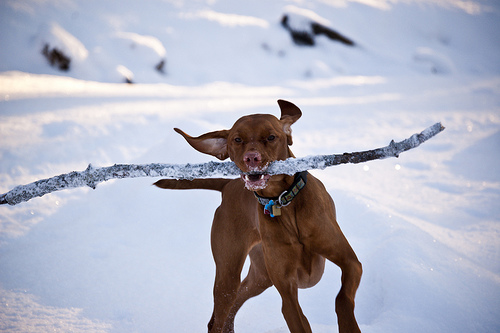

In [59]:
print(images_list[998])
Image.open(images_list[998])

In [46]:
combined_img_features = test_img_features
combined_img_features.update(valid_img_features)

In [1]:
samples = {}

for image in images_list:
    img = load_img(image, target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, image, tokenizer, max_length, combined_img_features)[0]
    caption = caption.replace("startseq ", "")
    caption = caption.replace(" endseq", "")
    samples[image] = caption

NameError: name 'images_list' is not defined

In [60]:
samples['./input/valid/3251976937_20625dc2b8.jpg']

'a brown dog is running through the snow'

In [66]:
# Make an actual captions file

actual_captions_file = "Images.csv"
header = ["Image", "Captions"]

with open(actual_captions_file, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    for image in images_list:
        if "test" in image:
            reference_captions = test.loc[test['filepath'] == image, 'captions'].tolist()
        else:
            reference_captions = valid.loc[valid['filepath'] == image, 'captions'].tolist()
        for i in range(5):
            reference_captions[i] = reference_captions[i].replace("startseq ", "")
            reference_captions[i] = reference_captions[i].replace(" endseq", "")
        row = [image, reference_captions]
        csvwriter.writerow(row)

In [67]:
# Make a predictions file

predictions_captions_file = "ViT-BiLSTM.csv"
header[1] = "Caption"

with open(predictions_captions_file, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(header)
    for image, caption in samples.items():
        row = [image, caption]
        csvwriter.writerow(row)

In [82]:
MOD = 1e9 + 7
bleu1 = 0
bleu2 = 0
bleu3 = 0
bleu4 = 0
length = 1000
images_pd = pd.read_csv(actual_captions_file)

for index, row in images_pd.iterrows():
    true_captions = ast.literal_eval(row['Captions'])
    actual = [ele.split() for ele in true_captions]

    predicted = samples[row['Image']].split()
    b1 = sentence_bleu(actual, predicted, weights=(1,0,0,0))
    b2 = sentence_bleu(actual, predicted, weights=(0.5,0.5,0,0))
    b3 = sentence_bleu(actual, predicted, weights=(0.3,0.3,0.3,0))
    b4 = sentence_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25))
    bleu1 = (bleu1 + b1) % MOD
    bleu2 = (bleu2 + b2) % MOD
    bleu3 = (bleu3 + b3) % MOD
    bleu4 = (bleu4 + b4) % MOD

print(f"BLEU-1 score: {(bleu1 / length) * 100}")
print(f"BLEU-2 score: {(bleu2 / length) * 100}")
print(f"BLEU-3 score: {(bleu3 / length) * 100}")
print(f"BLEU-4 score: {(bleu4 / length) * 100}")

BLEU-1 score: 54.13392914063466
BLEU-2 score: 33.35866250855063
BLEU-3 score: 17.300228850504766
BLEU-4 score: 5.73639416774857


In [84]:
meteor = 0

for index, row in images_pd.iterrows():
    true_captions = ast.literal_eval(row['Captions'])
    actual = [ele.split() for ele in true_captions]

    predicted = samples[row['Image']].split()
    m = meteor_score(actual, predicted)
    meteor = (meteor + m) % MOD

print(f"METEOR score: {(meteor / length) * 100}")

METEOR score: 35.96113223963391


In [86]:
# calculating rouge metric

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_precision = 0
rouge1_recall = 0
rouge1_fmeasure = 0
rouge2_precision = 0
rouge2_recall = 0
rouge2_fmeasure = 0
rougeL_precision = 0
rougeL_recall = 0
rougeL_fmeasure = 0

obj = {
    'rouge1': [0, 0, 0],
    'rouge2': [0, 0, 0],
    'rougeL': [0, 0, 0]
}

for index, row in images_pd.iterrows():
    reference_captions = ast.literal_eval(row['Captions'])
    candidate_caption = samples[row['Image']]
    # reference_captions = captions
    # candidate_caption = tokenizer.decode(t.generate(feature_extractor(Image.open(image).convert("RGB"), return_tensors="pt").pixel_values)[0])[6:-4]
    scores = {key: [] for key in ['rouge1', 'rouge2', 'rougeL']}
    r1_p_max = 0
    r1_r_max = 0
    r1_f_max = 0
    r2_p_max = 0
    r2_r_max = 0
    r2_f_max = 0
    rL_p_max = 0
    rL_r_max = 0
    rL_f_max = 0
    for ref in reference_captions:
        temp_scores = scorer.score(ref, candidate_caption)
        r1_p_max = max(r1_p_max, temp_scores['rouge1'].precision)
        r1_r_max = max(r1_r_max, temp_scores['rouge1'].recall)
        r1_f_max = max(r1_f_max, temp_scores['rouge1'].fmeasure)

        r2_p_max = max(r2_p_max, temp_scores['rouge2'].precision)
        r2_r_max = max(r2_r_max, temp_scores['rouge2'].recall)
        r2_f_max = max(r2_f_max, temp_scores['rouge2'].fmeasure)

        rL_p_max = max(rL_p_max, temp_scores['rougeL'].precision)
        rL_r_max = max(rL_r_max, temp_scores['rougeL'].recall)
        rL_f_max = max(rL_f_max, temp_scores['rougeL'].fmeasure)
        
    obj['rouge1'][0] = (obj['rouge1'][0] + r1_p_max) % MOD
    obj['rouge1'][1] = (obj['rouge1'][1] + r1_r_max) % MOD
    obj['rouge1'][2] = (obj['rouge1'][2] + r1_f_max) % MOD
    obj['rouge2'][0] = (obj['rouge2'][0] + r2_p_max) % MOD
    obj['rouge2'][1] = (obj['rouge2'][1] + r2_r_max) % MOD
    obj['rouge2'][2] = (obj['rouge2'][2] + r2_f_max) % MOD
    obj['rougeL'][0] = (obj['rougeL'][0] + rL_p_max) % MOD
    obj['rougeL'][1] = (obj['rougeL'][1] + rL_r_max) % MOD
    obj['rougeL'][2] = (obj['rougeL'][2] + rL_f_max) % MOD

print(f'Rouge1: Precision = {obj["rouge1"][0] * 100 / length}, Recall = {obj["rouge1"][1] * 100 / length}, f_measure = {obj["rouge1"][2] * 100 / length}')
print(f'Rouge2: Precision = {obj["rouge2"][0] * 100 / length}, Recall = {obj["rouge2"][1] * 100 / length}, f_measure = {obj["rouge2"][2] * 100 / length}')
print(f'RougeL: Precision = {obj["rougeL"][0] * 100 / length}, Recall = {obj["rougeL"][1] * 100 / length}, f_measure = {obj["rougeL"][2] * 100 / length}')

Rouge1: Precision = 46.32166639535703, Recall = 45.263408004646266, f_measure = 42.32488990432644
Rouge2: Precision = 21.484944322299885, Recall = 20.789392684199196, f_measure = 19.846473943305195
RougeL: Precision = 44.0802333707235, Recall = 43.6612551370236, f_measure = 40.65069155103612
